# Detecting Power Outages with Tweets
### Sang Cheon, Ethan Henley, and Jason Morman
### Appendix 01: Mapping

## Appendix 01 Summary

One of the elements of this project was to live-map power outage events based on social media data. Because this is just a proof of concept, we did not spend money on the Twitter Premium API, and so could not gather complete live data nor could we efficiently get location data more specific than the county level on which we searched. However, we wish to show what that kind of information might look like when implemented.

This notebook contains a set of functions that simulate random locations within a known more general location (county) and map them, approximating what a year of live outage tweet detection might look like for our test area, Washington State.

## Appendix 01 Contents:
- [Loading](#Loading)
- [Mapping Preprocessing](#Mapping-Preprocessing)
- [Mapping Major Outages](#Mapping-Major-Outages)
- [Mapping Predicted Outages](#Mapping-Predicted-Outages)
- [Conclusion](#Appendix-01-Conclusion)

## Loading

Imports.

In [1]:
import numpy as np

import pandas as pd

import imageio

import geopandas
from shapely.geometry import Point

import matplotlib.pyplot as plt

Map of WA by county, taken from a [map of the US by county from David Eldersveld](https://github.com/deldersveld/topojson).

In [2]:
# map of counties in USA
# converted to GeoJSON from TopoJSON
# from file from github.com/deldersveld/topojson
usa_map = geopandas.read_file('../data/2015_us_county_5m.json', 
                              driver='GeoJSON')

In [3]:
# washington state is no. 53 for some reason
mask = usa_map['STATEFP'] == '53'
wa_map = usa_map[mask]

Look at original, small set of outage tweets.

In [4]:
wa_tweets = pd.read_csv('../data/wa_tweets_preds.csv')
wa_outage_tweets = wa_tweets.loc[wa_tweets['outage']==1,
                                 ['event_row_or_county',
                                  'timestamp','text']]
wa_outage_tweets['event_row_or_county'] = \
    wa_outage_tweets['event_row_or_county'].map(int)

In [5]:
wa_outages = pd.read_csv('../data/washington_outages.csv')
wa_outages['index'] = wa_outages.index

## Mapping Preprocessing

Create GeoDataFrame of counties with major outages.

In [6]:
wa_map_all_o = pd.merge(wa_outages, wa_map[['NAME','geometry']],
                        left_on='Area Affected',
                        right_on='NAME')
wa_map_all_o = geopandas.GeoDataFrame(wa_map_all_o)

In [7]:
wa_map_all_o.head()

,Area Affected,index,Year,Month,Event Date and Time,Restoration Date and Time,Duration,Utility/Power Pool,NERC Region,Type of Disturbance,Loss (megawatts),Number of Customers Affected,NAME,geometry
0,King,0,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
1,King,4,2013,11.0,2013-11-02 00:00:00,2013-11-04 06:00:00,"54 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Heavy Winds,Unknown,105000,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
2,King,7,2014,10.0,2014-10-25 18:00:00,2014-10-25 18:00:00,ongoing,Puget Sound Energy,WECC,Severe Weather - Wind,154,96000,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
3,King,11,2014,12.0,2014-12-11 17:00:00,2014-12-12 10:00:00,"17 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather- High Winds,116,264000,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
4,King,19,2015,8.0,2015-08-29 11:00:00,2015-09-04 15:00:00,"148 Hours, 0 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",250,250000,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."


Create GeoDataFrame of tweets about outages.

In [8]:
wa_tweets_and_outages = pd.merge(wa_outage_tweets, wa_outages,
                                 left_on='event_row_or_county', 
                                 right_on='index'
                                )[['timestamp','text','Area Affected']]

In [9]:
wa_tweets_and_outages = \
    wa_tweets_and_outages[wa_tweets_and_outages['Area Affected'] != 'WA']

In [10]:
wa_map_1 = pd.merge(wa_tweets_and_outages, wa_map[['NAME','geometry']],
                    left_on='Area Affected',
                    right_on='NAME')
wa_map_1 = geopandas.GeoDataFrame(wa_map_1)

In [11]:
wa_map_1.head()

,timestamp,text,Area Affected,NAME,geometry
0,2012-01-19 22:55:20,@Number12ForLife No power in Issaquah Highland...,King,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
1,2012-01-19 22:26:31,@KING5Seattle @KIRO7Seattle tiger mountain rd ...,King,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
2,2012-01-19 22:24:36,@KING5Seattle @KIRO7Seattle SE may valley road...,King,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
3,2012-01-19 21:40:50,Just lost power. They power better be back on ...,King,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."
4,2012-01-19 20:32:02,Update: Power Outages Affecting Renton's Benso...,King,King,"MULTIPOLYGON (((-122.39642 47.77806, -122.3273..."


Create GeoDataFrame of tweets predicted to be about outages.

In [12]:
tweets_ambig = wa_tweets[wa_tweets['outage_prediction'] == 1
                        ].drop(columns=['outage','Cosine Similarity',
                                        'outage_prediction'])
tweets_ambig = tweets_ambig.reset_index(drop=True)

In [13]:
wa_map_u = pd.merge(tweets_ambig, wa_map[['NAME','geometry']],
                    left_on='event_row_or_county', right_on='NAME')
wa_map_u = geopandas.GeoDataFrame(wa_map_u)

## Mapping Major Outages

We'll first generate a map of counties affected by county-specific major outages.

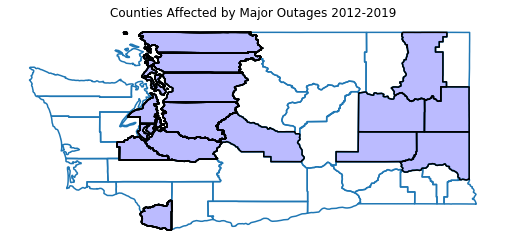

In [14]:
map_fig, map_ax = plt.subplots(1, 1, figsize = (10,4))
wa_map.boundary.plot(ax=map_ax)
wa_map_all_o.plot(ax=map_ax, color='#BBBBFF')
wa_map_all_o.boundary.plot(ax=map_ax, color='k')
plt.axis('off')
plt.title('Counties Affected by Major Outages 2012-2019')
plt.savefig(f'../figures/major_outage_counties.png');

We'll represent a tweet in a county as points randomly placed within its bounds. This is **not accurate location information**, but rather a proof of concept for how a live service might visualize outage tweets as they occur.

In [15]:
# function adapted from Kadir Şahbaz
# at gis.stackexchange.com/questions/294394
def rand_point_in_bounds(geom):
    bounds = geom.bounds
    while True:
        p = Point(np.random.uniform(bounds[0],bounds[2]),
                  np.random.uniform(bounds[1],bounds[3]))
        if geom.contains(p):
            break
    return p

We'll effectively be plotting points on top of a multi-layer map.

In [16]:
def plot_outages_during_year(year, twt_map, blank_map=wa_map, 
                             all_map = wa_map_all_o, major=True):
    
    map_fig, map_ax = plt.subplots(1, 1, figsize = (10,4))
    
    # plot blank boundaries
    blank_map.boundary.plot(ax=map_ax)
    
    # plot inspected counties
    all_map.plot(ax=map_ax, color='#BBBBFF')
    all_map.boundary.plot(ax=map_ax, color='k')
    
    # for year, plot appropriate num of random points in each county
    twt_map = twt_map[
        pd.to_datetime(twt_map.timestamp).map(lambda ts:ts.year) == year]
    np.random.seed(1007+year) # seed random for deterministic plots
    # include year so that it still varies by year
    points = geopandas.GeoSeries(
        [rand_point_in_bounds(geom) for geom in twt_map['geometry']])
    points.plot(ax=map_ax, color='r', marker='.')
    
    # formatting and text
    plt.axis('off')
    if major:
        plt.title(f'Tweets in WA about Major Outages, Yearly')
    else:
        plt.title(f'Tweets in WA predicted to be about Outages, Yearly')
    plt.text(x=-125,y=45.25,
             s='* specific locations beyond which county a tweet is '+\
             'from are simulated',size=10)
#     plt.legend(['County w/out major outage',
#                 'County w/ major outage',
#                 'Outage tweet'],
#                loc='lower right')
    plt.text(x=-125,y=48.75,s=f'Year: {year}',size=16)
    plt.tight_layout();

In the plot below, the filled in counties are counties that experienced a major outage between 2012 and 2019, and the red dots are simulated locations of tweets about major outages, each within the real county the tweet came from.

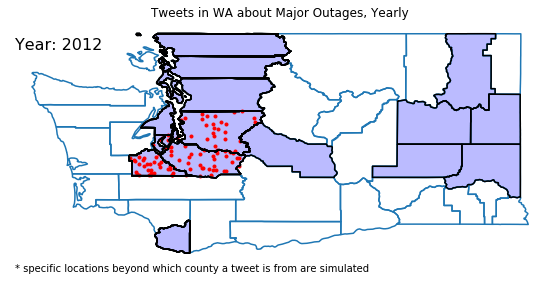

In [17]:
plot_outages_during_year(2012, wa_map_1)

Save a plot for each year of data.

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:309: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:309: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


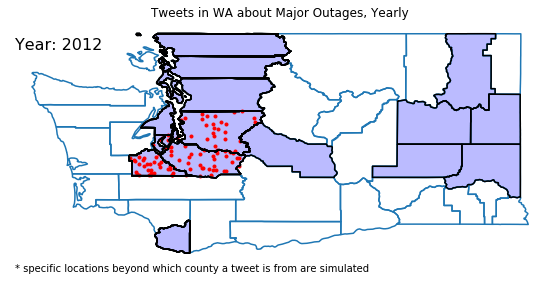

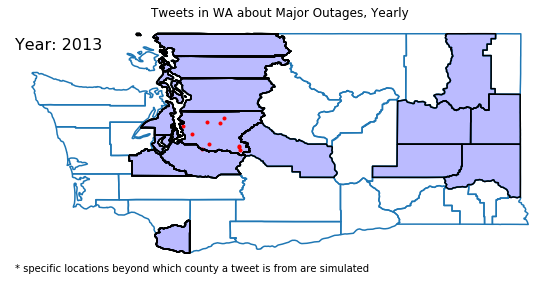

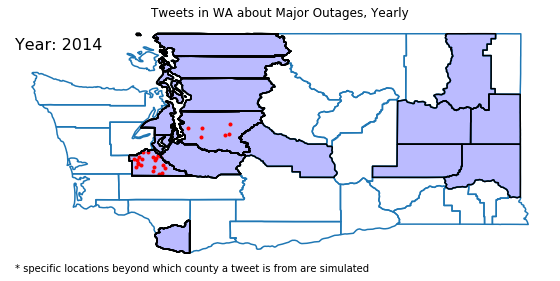

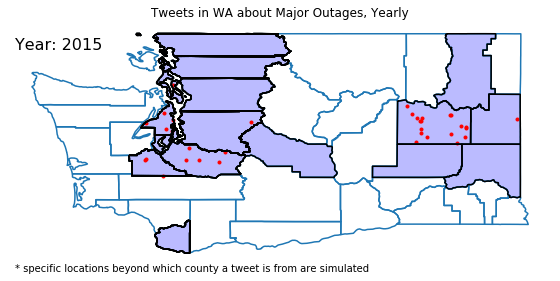

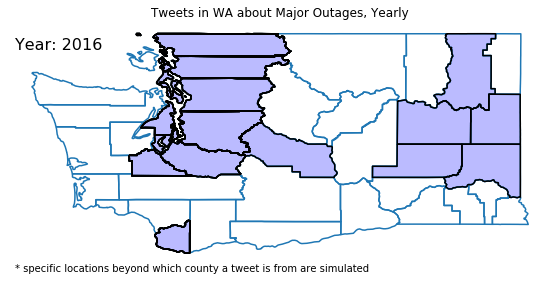

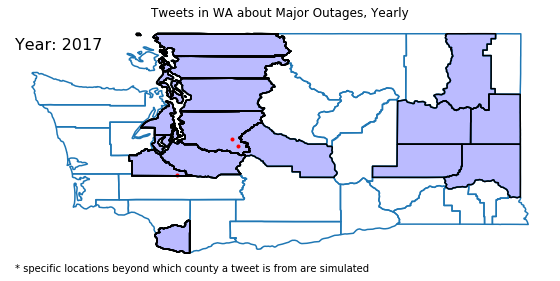

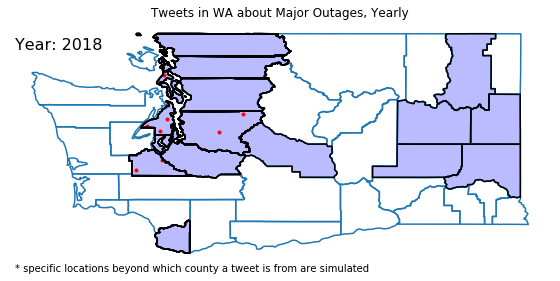

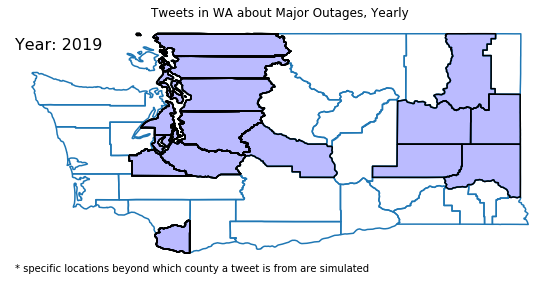

In [18]:
for year in range(2012,2020):
    plot_outages_during_year(year, wa_map_1)
    plt.savefig(f'../figures/major_outage_tweets_{year}.png');

Convert .png series to gif using imageio.

In [19]:
fnames = [f'../figures/major_outage_tweets_{year}.png' 
          for year in range(2012,2020)]
images = [imageio.imread(f) for f in fnames]
imageio.mimsave('../figures/major_outage_tweets.gif', images, duration=2)

## Mapping Predicted Outages

The workflow for this is about the same as it was for known outages. Again, we **do not use accurate location data** beyond which county a tweet is from.

In the plot below, the filled in counties are counties that experienced a major outage between 2012 and 2019, and the red dots are simulated locations of tweets predicted to be about outages for the year 2012, each within the real county the tweet came from (and limited to the set of counties that experienced major outages).

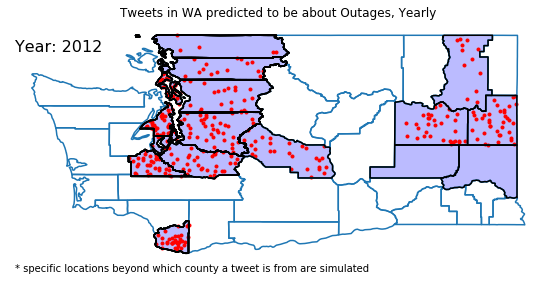

In [20]:
plot_outages_during_year(2012, wa_map_u, major=False)

Save a plot for each year of data.

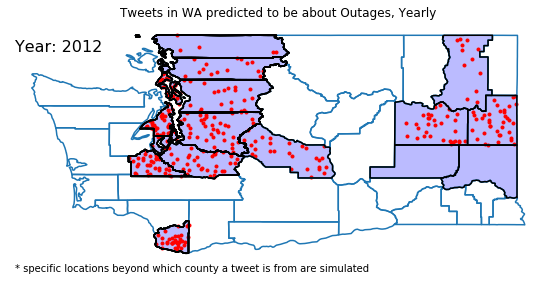

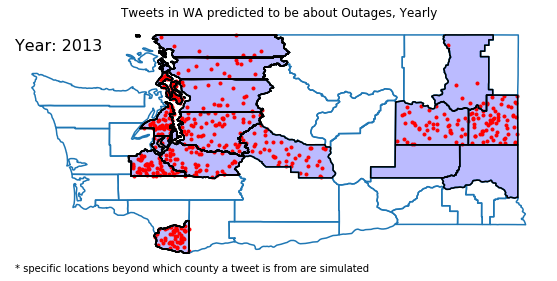

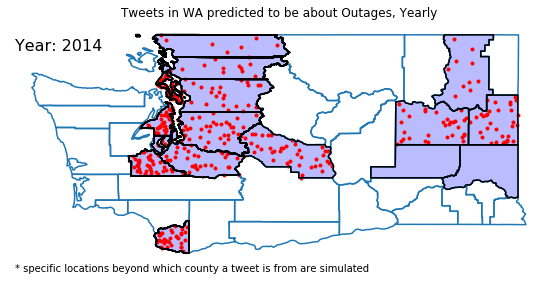

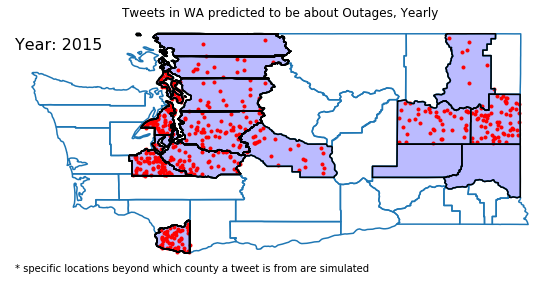

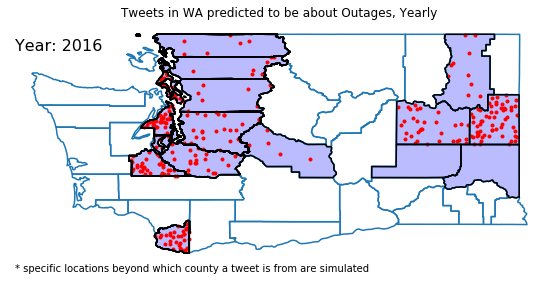

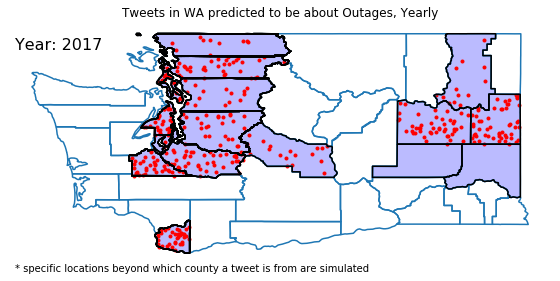

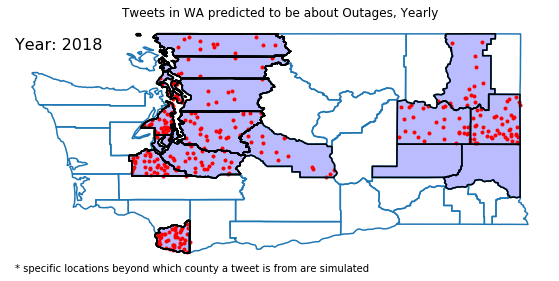

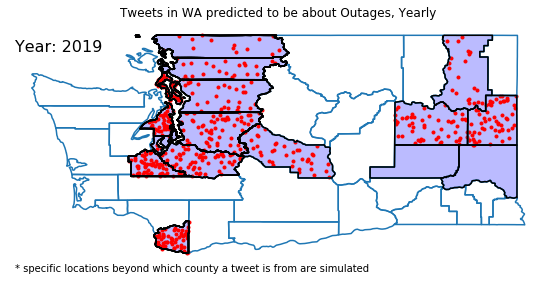

In [21]:
for year in range(2012,2020):
    plot_outages_during_year(year, wa_map_u, major=False)
    plt.savefig(f'../figures/pred_outage_tweets_{year}.png');

Convert .png series to gif using imageio.

In [22]:
# adapted from Almar's answer at
# stackoverflow.com/questions/753190
fnames = [f'../figures/pred_outage_tweets_{year}.png' 
          for year in range(2012,2020)]
images = [imageio.imread(f) for f in fnames]
imageio.mimsave('../figures/pred_outage_tweets.gif', images, duration=2)

## Appendix 01 Conclusion

The `.gif`s generated by this notebook simulate annual catalogues of location-precise outage tweet collection. Should this project be expanded beyond a proof of concept, a non-simulated version should be feasible. These maps display the potential for Twitter-based outage detection—we have many more tweets predicted to represent outages than we do tweets in our positive class (i.e. tweets including 'power,' 'outage,' or 'blackout' from an affected county during a major outage), even restricted to the same set of counties. Our model can provide a ground-level view greatly more sensitive to small or localized outages than a default query dependent on reported, major events.